In [191]:
# -*- coding: utf-8 -*-

import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [192]:
raw_df = pd.read_csv("data/posco_with_var.csv")   #read data
#raw_df.columns = ['date', 'stand_price', 'fluc_price', 'fluc_rate']
row_num = len(raw_df['date'])   # the number of rows
col_num = len(df.columns)
raw_df.head()
df = raw_df   # change dataframe with all variables
data_total = np.zeros((col_num-1, row_num))
data_total[0]
df.head()

,date,bhp,rio,vale,wti,brzil_2,jogang,china_sen,china_jo,pmi,china_us,price
0,2009-01-02,45.509998,24.850000,13.19,46.17,2.3230,86420.0,3593.11,41192.0,58.4,6.8363,79.0
1,2009-01-09,43.880001,25.027500,13.87,40.69,2.2821,86420.0,3593.11,41192.0,58.4,6.8383,77.5
2,2009-01-16,40.450001,22.192499,12.96,35.38,2.3250,86420.0,3593.11,41192.0,58.4,6.8380,81.0
3,2009-01-23,37.880001,21.525000,13.03,45.12,2.3541,86420.0,3593.11,41192.0,58.4,6.8371,81.0
4,2009-01-30,37.540001,21.687500,14.11,41.73,2.3127,86420.0,3593.11,41192.0,58.4,6.8334,80.5


In [194]:
for i in range(col_num-1):
    col = i+1
    column = np.reshape(np.array(df.iloc[:,[col]]),-1)
    data_total[i] = column
np.shape(data_total)
Dataxy = data_total

In [195]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [179]:
a = np.array(data_total[:,1:3]).T
#print(a)
np.reshape(np.array(a[0:2]), -1)
#data_total[10,:]
np.random.shuffle(a)

In [242]:
input_size = 1
num_steps = 1
hidden_size = 10
lstm_size = 128
output_size = 1
learning_rate = 0.01
iterations = 500
num_layers = 2
patience = 10
kept_error = 10**8


# Data preparation
seq = MinMaxScaler(Dataxy)   # Normalization: unless being out of scale?
seq_y = seq[10,:]
len(Dataxy)

11

In [243]:
#seq = Dataxy
seq = [np.reshape(seq[:, i * input_size: (i + 1) * input_size].T,-1) for i in range(row_num // input_size)]
seq_y = [np.array(seq_y[i * input_size: (i + 1) * input_size]) 
       for i in range(row_num // input_size)]
print(len(seq))

476


In [234]:
# Split into groups of `num_steps`
dataX = np.array([seq[i: i + num_steps] for i in range(len(seq) - num_steps)])
dataY = np.array([seq_y[i + num_steps] for i in range(len(seq_y) - num_steps)])
print(len(dataX))

475


In [241]:
train_size = int(len(dataY) * 0.8)
valid_size = train_size - int(train_size*0.8)  # validation set: 20% of train set
test_size = len(dataY) - train_size
trainX, validX, testX = np.array(dataX[0:train_size-valid_size]), np.array(dataX[train_size-valid_size:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, validY, testY = np.array(dataY[0:train_size-valid_size]), np.array(dataY[train_size-valid_size:train_size]), np.array(
    dataY[train_size:len(dataY)])

# train_size = int(len(dataY) * 0.9)
# #valid_size = train_size - int(train_size*0.9)
# test_size = len(dataY) - train_size
# trainX, testX = np.array(dataX[0:train_size]), np.array(
#     dataX[train_size:len(dataX)])
# trainY, testY = np.array(dataY[0:train_size]), np.array(
#     dataY[train_size:len(dataY)])
len(trainX)

304

[iteration:1] kept_error:3.4331456845393404e-05
[iteration:2] kept_error:2.568667332525365e-05
[iteration:3] kept_error:1.853983303590212e-05
[iteration:4] kept_error:1.445925772713963e-05
[iteration:5] kept_error:1.2833979781134985e-05
[iteration:6] kept_error:1.2095843885617796e-05
[iteration:7] kept_error:1.1331318091833964e-05
[iteration:8] kept_error:1.0171509529754985e-05
[iteration:10] kept_error:7.807811925886199e-06
[iteration:20] kept_error:6.870736342534656e-06
[iteration:29] kept_error:4.743982117361156e-06
[iteration:30] kept_error:3.5151704196323408e-06
[iteration:31] kept_error:2.8124359232606366e-06
RMSE: 0.00020355911692604423, predict:[[0.00054362]
 [0.00054192]
 [0.00052797]
 [0.0005267 ]
 [0.00051829]
 [0.00052415]
 [0.00052944]
 [0.00060342]
 [0.00060412]
 [0.00061019]
 [0.00061857]
 [0.00085228]
 [0.00087436]
 [0.00087479]
 [0.00088552]
 [0.00065844]
 [0.00066883]
 [0.00066646]
 [0.00065903]
 [0.00066259]
 [0.00071748]
 [0.00072869]
 [0.00073423]
 [0.00074054]
 [0

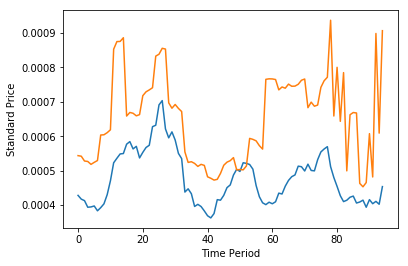

In [236]:
input_dim = 11
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, num_steps, input_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a stacked LSTM network
def create_one_lstm_cell():
    return tf.contrib.rnn.LSTMCell(lstm_size, state_is_tuple=True)

multi_cells = tf.contrib.rnn.MultiRNNCell([create_one_lstm_cell() for _ in range(num_layers)], state_is_tuple=True
                ) if num_layers > 1 else create_one_lstm_cell()

outputs, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_size, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

j = 0
iteration_num = 0

# train with early stopping
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    # Training step
    while j < patience:
        iteration_num += 1
        for i in range(iterations):
            _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        temp_error = sess.run(loss, feed_dict = {X: validX, Y: validY})
        if temp_error < kept_error:
            j = 0
            #save_path = saver.save(sess, "/tmp/model_es.ckpt")
            kept_error = temp_error
            print("[iteration:{}] kept_error:{}".format(iteration_num, kept_error))
            #print("[step: {}] loss: {}".format(i, step_loss))
        else:
            j += 1
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}, predict:{}".format(rmse_val, test_predict))

# with tf.Session() as sess:
#     init = tf.global_variables_initializer()
#     sess.run(init)

#     # Training step
#     for i in range(iterations):
#         _, step_loss = sess.run([train, loss], feed_dict={
#                                 X: trainX, Y: trainY})
#         print("[step: {}] loss: {}".format(i, step_loss))

#     # Test step
#     test_predict = sess.run(Y_pred, feed_dict={X: testX})
#     rmse_val = sess.run(rmse, feed_dict={
#                     targets: testY, predictions: test_predict})
#     print("RMSE: {}, predict:{}".format(rmse_val, test_predict))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Standard Price")
    plt.show()
 